# Deep Neural Network
We will build a flexible neural network with L layers that can have different hidden layer units in each layer.

## Structure
1. Import packages and load data.
2. Standardize data to have feature values between 0 and 1.
3. Define all L layers with their number of hidden units and activation function for each layer.
4. Initialize parameters.
5. Loop for num_iterations:
   - Forward propagation
   - Compute cost function
   - Backward propagation
   - Update parameters (using parameters, and grads from backprop) 
6. Use trained parameters to predict labels

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline 
#display the output of plotting commands on the frontend of the notebook.
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
# interpolation='nearest' simply displays an image without trying to interpolate between pixels if 
# the display resolution is not the same as the image resolution (which is most often the case). 
# It will result an image in which pixels are displayed as a square of multiple pixels.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' # set the default color map

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5','r')
    #print(list(train_dataset.keys())) #shows a list of column headings in a h5py file.
    x_train_orig = np.array(train_dataset['train_set_x'][:])
    y_train = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('test_catvnoncat.h5','r')
    x_test_orig = np.array(test_dataset['test_set_x'][:])
    y_test = np.array(test_dataset['test_set_y'][:])

    classes = np.array(train_dataset['list_classes'][:])

    # now we have to reshape our output values to make it into a vector
    y_train = y_train.reshape(1,y_train.shape[0])
    y_test = y_test.reshape(1,y_test.shape[0])
    # print(x_train_orig.shape, y_train.shape, x_test_orig.shape, y_test.shape) will output
    #      (209, 64, 64, 3)     (1, 209)       (50, 64, 64, 3)    (1, 50)
    return (x_train_orig, y_train, x_test_orig, y_test)

In [3]:
def transform_data(x_train_orig, x_test_orig):
    """
    Arguments:
    x_train_orig -- input training values of dimensions (209, 64, 64, 3)
    x_test_orig -- input test values of dimensions (50, 64, 64, 3)
    
    Returns:
    x_train -- transformed input training values of dimensions (12288, 209)
    x_test -- transformed input test values of dimensions (12288, 50)
    """
    
    # now we have to reshape our data to make our input vector 
    x_train = x_train_orig.reshape(x_train_orig.shape[0], -1).T
    x_test = x_test_orig.reshape(x_test_orig.shape[0], -1).T
    # the "-1" makes reshape flatten the remaining dimensions

    # Standardize data to have feature values between 0 and 1.
    x_train = x_train/255
    x_test = x_test/255
    # generally to standardize data between 0 and 1, we divide all values by the maximum possible value,
    # which here is the maximum value of a pixel: 255
    return (x_train, x_test)

In [4]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1) # It is used to keep all the random function calls consistent.
    parameters = {}
    L = len(layer_dims) #total number of layers of the neural network
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])/ np.sqrt(layer_dims[l-1])#*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [5]:
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def relu(z):
    a = np.maximum(0,z)
    return a

def dZ_sigmoid(dA, z):
    s = sigmoid(z)
    dZ = dA * s * (1-s)
    return dZ

def dZ_relu(dA,z):
    dZ = np.array(dA, copy = True) # copy input values into an array to avoid overwriting on the same values
    dZ[z<=0] = 0 # slope for values <=0 would be 0 else 1
    return dZ

In [6]:
def forward_pass(X, parameters, activation):
    """
    Arguments:
    X -- input values of dimension(12288, 209)
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    Y_pred -- predicted output values of dimension(1,209)
    Z_cache -- the input of the activation function of all layers in a dictionary
    A_cache -- the output of activation function of all layers in a dictionary
    """
    L = len(activation)
    A_prev = X
    Z_cache = {}
    A_cache = {'A0':X}
    for l in range(L):
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
        Z = np.dot(W,A_prev)+b
        if activation[l] == 'sigmoid':
            A = sigmoid(Z)
        elif activation[l] == 'relu':
            A = relu(Z)
        A_prev = A
        Z_cache['Z' + str(l+1)] = Z
        A_cache['A' + str(l+1)] = A
    Y_pred = A
    return (Y_pred, Z_cache, A_cache)

In [7]:
def compute_cost(Y_pred, Y):
    """
    Arguments:
    Y_pred -- predicted output values of dimension(1,209)
    Y -- original output values of dimension(1,209)
    
    Returns:
    cost -- cross entropy cost
    dCost -- derivative of the cross entropy cost function of dimension (1,209)
    """
    m = Y.shape[1]
    cost = (-1/m) * (np.dot(Y,np.log(Y_pred).T) + np.dot(1-Y,np.log(1-Y_pred).T))
    dCost = - (np.divide(Y,Y_pred) - np.divide(1-Y,1-Y_pred))
    return cost, dCost

In [8]:
def backward_pass(dCost, Z_cache, A_cache, activation, parameters):
    """
    Arguments:
    dCost -- derivative of the cross entropy cost function of dimension (1,209)
    Z_cache -- the input of the activation function of all layers in a dictionary
    A_cache -- the output of activation function of all layers in a dictionary
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    
    Returns:
    grads -- dictionary containing gradients (dW and db) of all layers
    """
    dA = dCost
    m = dA.shape[1]
    grads = {}
    L = len(activation)
    for l in reversed(range(L)):
        # 3 2 1 0
        #print(list(A_cache.keys())[l])
        A_prev = A_cache['A' + str(l)]
        Z = Z_cache['Z' + str(l+1)]
        W = parameters['W' + str(l+1)]
        if activation[l] == 'sigmoid':
            dZ = dZ_sigmoid(dA, Z)
        elif activation[l] == 'relu':
            dZ = dZ_relu(dA, Z)
        dW = (1/m) * np.dot(dZ,A_prev.T)
        db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T,dZ)
        grads['dW' + str(l+1)] = dW
        grads['db' + str(l+1)] = db
    return grads 

In [9]:
def update_params(grads, parameters, learning_rate):
    """
    Arguments:
    grads -- dictionary containing gradients (dW and db) of all layers
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    learning_rate -- learning rate to set the speed of model training
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    L = len(grads)//2
    for l in range(L):
        parameters['W' + str(l+1)] -= learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] -= learning_rate * grads['db' + str(l+1)]
    return parameters

In [10]:
def train_model(x_train, y_train, parameters, activation, num_iterations = 3000, print_cost=False):
    m = y_train.shape[1]
    costs = []
    for i in range(num_iterations):
        Y_pred, Z_cache, A_cache = forward_pass(x_train, parameters, activation)
        cost, dCost = compute_cost(Y_pred, y_train)
        grads = backward_pass(dCost, Z_cache, A_cache, activation, parameters)
        parameters = update_params(grads, parameters, learning_rate)
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs)) # plot the cost
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()     
    return parameters, costs

In [11]:
def predict(X, Y, parameters, activation):
    """
    Arguments:
    X -- input data set
    Y -- original output of the data set 
    parameters -- parameters of the trained model
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    Y_pred, Z_cache, A_cache = forward_pass(X, parameters, activation)
    # convert output to 0/1 predictions
    p[Y_pred>0.5] = 1 # if true then 1 else 0
    accuracy = np.sum(p == Y)*(100/m)
    return accuracy

## Final Implementation

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.3691258524959279
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.107839285262

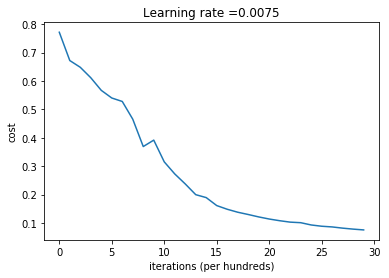

In [12]:
# hyperparameters
num_iterations = 3000
learning_rate = 0.0075
layers_dims = [20, 7, 5, 1] # no. of hidden layer units in each hidden layer
activation = ['relu', 'relu', 'relu', 'sigmoid'] #activation function (relu/sigmoid) corresponding to each hidden layer.
#activation function for the output layer will be sigmoid function.

#execution
#import_libraries()
x_train_orig, y_train, x_test_orig, y_test = load_data()
x_train, x_test = transform_data(x_train_orig, x_test_orig)
m = y_train.shape[1]
layers_dims.insert(0,x_train.shape[0])
parameters = initialize_parameters(layers_dims)
parameters, costs = train_model(x_train, y_train, parameters, activation, num_iterations, print_cost = True)

In [13]:
predictions_train = predict(x_train, y_train, parameters, activation)
print('Accuracy for training dataset: ' + str(predictions_train) + '%')
predictions_test = predict(x_test, y_test, parameters, activation)
print('Accuracy for test dataset: ' + str(predictions_test) + '%')

Accuracy for training dataset: 99.04306220095694%
Accuracy for test dataset: 82.0%
